Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Initialization

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:  
    from google.colab import drive
    drive.mount('/content/drive')

    # packages to generate requirement.txt
    %pip install nbconvert
    %pip install pipreqs
    # for Frechet inception distance
    %pip install pytorch-fid

    %cd drive/My Drive/optml_gan2
    PATH = './' 
else:
    PATH = './' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/My Drive/optml_gan2


In [2]:
from __future__ import print_function

import argparse
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from datetime import datetime
import json
import pickle
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
%matplotlib inline

# Set random seed for reproducibility
manualSeed = 123

#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


# Generate Requirements

In [3]:
# # converts notebook to .py file for pipreqs
# !jupyter nbconvert --output-dir="./" --to script dcgan.ipynb 

# # creates the requirement.txt file
# !pipreqs --force
# os.remove('./dcgan.py')  # deletes the .py file

# Source code

## Data handling

In [4]:
# there are problems with downloading CelebA
# see https://stackoverflow.com/questions/65528568/how-do-i-load-the-celeba-dataset-on-google-colab-using-torch-vision-without-ru

def get_dataset(name, image_size):
    # torchvision dataset
    dataset = None

    # number of channels in the training images (3 for color, 1 for grayscale)
    nc = None

    if name == 'cifar10':
        nc = 3

        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # todo: Why do we use these means and stds ? 
        )])

        dataset = torchvision.datasets.CIFAR10(dataroot, download=True, 
                                            train=True,  transform=transform)
    elif name == 'mnist':
        nc = 1

        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)) # todo: Why do we use these means and stds and not the mean and std of the dataset?
        ])

        dataset = torchvision.datasets.MNIST(dataroot, download=True, 
                                            train=True,  transform=transform)
    else:
        raise ValueError("Unknown dataset name")
    
    return dataset, nc

In [5]:
def plot_img(dataloader, dataset_name):
    # Plot some training images
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.savefig(PATH + 'img/training_images_' + dataset_name, format="png",dpi=400)
    return

## Utils

In [6]:
def count_parameters(model):
    # from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
# Paths to load and save the models

def generate_paths(PATH, extra_word, loss_name, lrD, lrG, beta1, iter_dis, iter_gen, gp_va,create_dir):

    param_str = loss_name + 'Loss_'  + 'lrd' + str(lrD) + '_lrg' + str(lrG) + '_b1' +  'b' + str(beta1)  
    param_str = param_str + '_itd' + str(iter_dis) + '_itg' + str(iter_gen) +'_gpv' + str(gp_val) + '_'

    experiment_path = PATH + "generated_data/" + extra_word + param_str  + str(datetime.date(datetime.now())).replace('-', '_') + "_"
    
    models_path = experiment_path + '/models/'

    stats_path = experiment_path + '/stat.pickle'
    if create_dir:
        os.makedirs(models_path, exist_ok=True)
        os.makedirs(experiment_path, exist_ok=True)
    return experiment_path, stats_path, models_path

def model_paths(experiment_path, epoch, models_path):
  
    model_name_G = 'model_G_' + str(epoch)
    save_path_G = models_path + model_name_G

    model_name_D = 'model_D_'+str(epoch)
    save_path_D = models_path + model_name_D

    return save_path_G, save_path_D

## Model

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
def init_net(model, device):
    # Create the generator
    net = model.to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        net = nn.DataParallel(net, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    #net.apply(weights_init)

    # Print the model
    print(net)
    return net

## Losses

In [10]:
# stability constant
EPS = 1e-15


# KL-divergence
def loss_gen_kl(dis_output, eps=EPS):
    return - torch.log(dis_output + eps).mean() 

def loss_dis_kl(dis_output_real, dis_output_fake, eps=EPS):
    return - (torch.log(dis_output_real + eps)).mean() - (torch.log(1. - dis_output_fake + eps)).mean()


# Wasserstein distance
# Requires special output of the network + weight clipping / grad penalty
def loss_gen_wasser(dis_output, eps=EPS):
    return - dis_output.mean()

def loss_dis_wasser(dis_output_real, dis_output_fake, eps=EPS):
    return - (dis_output_real.mean() - dis_output_fake.mean())


# Hinge loss
def loss_gen_hinge(dis_output, eps=EPS):
    return - dis_output.mean()

def loss_dis_hinge(dis_output_real, dis_output_fake, eps=EPS):
    return torch.nn.ReLU()(1.0 - dis_output_real).mean() + torch.nn.ReLU()(1.0 + dis_output_fake).mean()


loss_dict = {
    "kl"    : (loss_dis_kl, loss_gen_kl),
    "wass"  : (loss_dis_wasser, loss_gen_wasser),
    "hinge" : (loss_dis_hinge, loss_gen_hinge)
}

## FID

https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid/notebook  
https://github.com/mseitzer/pytorch-fid   
currently uses the kaggle stuff since calculating FID on the repo is run from commandline

In [11]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
import torchvision.models as models

In [12]:
def calculate_activation_statistics(images,inception_model,batch_size=128, dims=2048,
                    cuda=False):
    inception_model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images

    pred = inception_model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [13]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [14]:
def calculate_frechet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretchet distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

## Training

In [15]:
def init_optimizers(netD, netG, lrD, lrG, beta1, nz, device):
    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # todo: outdated now
    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

    return fixed_noise, real_label, fake_label, optimizerD, optimizerG

def init_losses(loss_type):
    if loss_type not in loss_dict.keys():
        raise Exception("Unknown loss type")

    return loss_dict[loss_type]

In [16]:
from torch.autograd import Variable

def gradient_penalty(device, discriminator, data_gen, data_real, lambda_reg=0.1):
    alpha = torch.rand(data_real.shape[0], 1).to(device)
    dims_to_add = len(data_real.size()) - 2
    for i in range(dims_to_add):
        alpha = alpha.unsqueeze(-1)

    interpolates = (alpha * data_real + ((1. - alpha) * data_gen)).to(device)

    interpolates = Variable(interpolates, requires_grad=True)

    disc_interpolates = discriminator(interpolates)
    grad_outputs = torch.ones(disc_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates, grad_outputs=grad_outputs,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    gp_val = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg

    return gp_val

In [17]:
def discriminator_step(f_loss_dis, netD, netG, data, device, real_label, fake_label, gp_coef):
    netD.zero_grad()

    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output_real = netD(real_cpu).view(-1)

    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_label)
    output_fake = netD(fake.detach()).view(-1)

    errD = f_loss_dis(output_real, output_fake)

    if gp_coef != 0.0:
        errD += gp_coef * gradient_penalty(device, netD, fake, real_cpu)

    errD.backward()
    optimizerD.step()

    D_x = output_real.mean().item()
    D_G_z1 = output_fake.mean().item()

    return D_x, D_G_z1, errD, label, fake, real_cpu


def generator_step(f_loss_gen, netD, netG, label, fake, real_label):
    netG.zero_grad()
    output = netD(fake).view(-1)
    
    errG = f_loss_gen(output)
    errG.backward()
    
    D_G_z2 = output.mean().item()

    optimizerG.step()
    return D_G_z2, errG

In [18]:
class Training:
    def __init__(self, loss_name, netD, netG, device, real_label, fake_label, dataloader, num_epochs,
                 fixed_noise, gp_val, lrD, lrG, beta1, experiment_prefix, save_models, 
                 PATH, save_stats, create_dir=True, iter_per_epoch_dis=1, iter_per_epoch_gen=1, grad_penalty_coef=0.0):
      
        self.loss_name = loss_name
        self.netD, self.netG = netD, netG
        self.device = device
        self.real_label, self.fake_label = real_label, fake_label
        self.dataloader = dataloader
        self.num_epochs = num_epochs
        self.fixed_noise = fixed_noise
        self.iter_per_epoch_dis, self.iter_per_epoch_gen = iter_per_epoch_dis, iter_per_epoch_gen
        self.grad_penalty_coef = grad_penalty_coef

        self.save_models = save_models
        self.PATH = PATH
        self.experiment_prefix = experiment_prefix
        self.loss_name = loss_name
        self.lrD = lrD
        self.lrG = lrG
        self.beta1 = beta1
        self.gp_val = gp_val
        self.create_dir = create_dir
        self.save_stats = save_stats
        
        self.experiment_path, self.stats_path, self.models_path = generate_paths(self.PATH, self.experiment_prefix, 
                                                          self.loss_name, self.lrD, self.lrG, 
                                                          self.beta1, self.iter_per_epoch_dis, self.iter_per_epoch_gen, 
                                                          self.gp_val, self.create_dir)
        
        
        

        # self.inception_model = inception_model
    def _output_training_stats(self, epoch, i, size, errD, errG, D_x, D_G_z1, D_G_z2, t0):
        if i == size:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f t: %2.3f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD, errG, D_x, D_G_z1, D_G_z2, time.time()-t0))
        elif i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD, errG, D_x, D_G_z1, D_G_z2))
    
    def _save_gen_output(self, iters, epoch, i):
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            self.img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # maybe remove this if we have memory problems
            self.img_list_nogrid.append(fake)

    def train(self):
        f_loss_dis, f_loss_gen = init_losses(self.loss_name)

        G_losses, D_losses = [], []
        self.img_list = []
        self.img_list_nogrid = []

        iters = 0

        print("Starting Training Loop...")

        D_x, D_G_z1, errD, label, fake = None, None, None, None, None
        D_G_z2, errG = None, None

        for epoch in range(self.num_epochs):
            t0 = time.time()

            

            for i, data in enumerate(self.dataloader, 0):
                for _ in range(self.iter_per_epoch_dis):
                    D_x, D_G_z1, errD, label, fake, real_cpu = discriminator_step(
                        f_loss_dis, self.netD, self.netG, data, self.device, 
                        self.real_label, self.fake_label, self.grad_penalty_coef
                    )

                for _ in range(self.iter_per_epoch_gen):
                    D_G_z2, errG = generator_step(
                        f_loss_gen, self.netD, self.netG, label, fake, self.real_label
                    )
                
                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                size = len(dataloader) - 1
                self._output_training_stats(epoch, i, size, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, t0)
                
                # Check how the generator is doing by saving G's output on fixed_noise
                self._save_gen_output(iters, epoch, i)
                
                iters += 1

            # save the model at the end of every epoch
            if self.save_models :
                self.save_path_G, self.save_path_D = model_paths(self.experiment_path, epoch, self.models_path)
                save_models(self.netG, self.netD, self.save_path_G, self.save_path_D)

        stats = {
            'img_list' : self.img_list,
            'img_list_nogrid' : self.img_list_nogrid,
            'G_losses' : G_losses,
            'D_losses' : D_losses  
        }
        if self.save_stats:
            pickle_save(stats, self.stats_path)

        return stats

## Visualization

In [19]:
def plot_loss(G_losses, D_losses, save = False):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

    if save == True:
      plt.savefig(PATH + 'img/loss', format="png",dpi=400)

    plt.show()
    return

In [20]:
def plot_realvsfake(dataloader, device, img_list, save = False):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    if save == True:
        plt.savefig(PATH + 'img/real_vs_fake', format="png",dpi=400)
    plt.show()
    return

## Serialization

In [21]:
def save_models(netG ,netD, save_path_G, save_path_D):
    torch.save(netG.state_dict(), save_path_G)
    torch.save(netD.state_dict(), save_path_D)
    print('GAN saved')
    return

In [22]:
def load_models(ngpu, Discriminator, Generator, save_path_G, save_path_D):
  
    netD = init_net(Discriminator(ngpu, nc, loss_name), device)
    netD.load_state_dict(torch.load(save_path_D))
    netD.eval()

    netG = init_net(Generator(ngpu, nc, nz), device)
    netG.load_state_dict(torch.load(save_path_G))
    netG.eval()
    
    print('GAN loaded')
    return netD, netG

In [23]:
def save_dict(dict, dict_path):
    with open(dict_path, 'w') as file:
        file.write(json.dumps(dict))  
    return

def read_dict(dict_path):
    with open(dict_path) as f:
        data = f.read()
    data = json.loads(data)
    return data

def pickle_save(something, path):
    with open(path, 'wb') as handle:
        pickle.dump(something, handle, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_load (path):
    with open(path, 'rb') as handle:
        something = pickle.load(handle)
    return something

## Architectures

https://keras.io/examples/generative/conditional_gan/

In [24]:
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(nz, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, nc * 28 * 28)
        return    

    # forward method
    def forward(self, x): 
        x = x.reshape([x.shape[0], -1])

        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        x = x.reshape((-1, nc, 28, 28))
        return x
    

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc, loss):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)

        self.fc4 = nn.Linear(self.fc3.out_features, 1)

        if loss == "kl":
            # for KL - discriminator is a classifier
            self.act = torch.sigmoid
        else:
            # for Wasserstein and hinge - discriminator is a critic
            self.act = lambda x: x

        return    

    def forward(self, x):
        x = x.reshape([x.shape[0], -1])
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = self.act(self.fc4(x))
        return x

# Training

## Parameters

In [25]:
# Root directory for dataset
dataroot = PATH + "data/"

# Dataset name
dataset_name = 'mnist' # 'cifar10' or 'mnist'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28 # 28 for mnist, 64 for others

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [32]:
# Number of training epochs
num_epochs = 3

# Learning rate for optimizers
lrD = 2e-4
lrG = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.9 # 0.9 == default

In [35]:
dataset, nc = get_dataset(dataset_name, image_size)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#print(dataset)
#plot_img(dataloader, dataset_name)

In [36]:
loss_name = "wass" # wass, hinge
iter_dis, iter_gen, gp_val = 1, 1, 0.0

if loss_name == "wass":
    iter_dis, gp_val = 5, 10.0


netG = init_net(Generator(ngpu, nc, nz), device)
print('Generator parameters', count_parameters(netG))

netD = init_net(Discriminator(ngpu, nc, loss_name), device)
print('Discriminator parameters', count_parameters(netD))

Generator(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Generator parameters 1493520
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)
Discriminator parameters 1460225


## Run

In [37]:
fixed_noise, real_label, fake_label, optimizerD, optimizerG = init_optimizers(netD, netG, lrD, lrG, beta1, nz, device)

In [38]:
experiment_prefix = '' # and extra word to add the automatically generated one if you really need it, ideally keep empty

In [39]:
gan_training = Training(loss_name, netD, netG, device, real_label, fake_label, 
                        dataloader, num_epochs, fixed_noise, 
                        gp_val, lrD, lrG, beta1, experiment_prefix, save_models, PATH, save_stats = True, create_dir=True,
                        iter_per_epoch_dis=1, iter_per_epoch_gen=1, grad_penalty_coef=0.0)

stats = gan_training.train()

Starting Training Loop...
[0/3][0/469]	Loss_D: 0.0329	Loss_G: 0.0411	D(x): -0.0725	D(G(z)): -0.0396 / -0.0411
[0/3][50/469]	Loss_D: -23.1481	Loss_G: -91.3069	D(x): 117.6916	D(G(z)): 94.5436 / 91.3069
[0/3][100/469]	Loss_D: -4184.4160	Loss_G: 1300.5298	D(x): 2978.6567	D(G(z)): -1205.7592 / -1300.5298
[0/3][150/469]	Loss_D: 5252.5068	Loss_G: -11201.0410	D(x): 6321.0957	D(G(z)): 11573.6025 / 11201.0410
[0/3][200/469]	Loss_D: -152.0244	Loss_G: -3598.1350	D(x): 3810.0962	D(G(z)): 3658.0718 / 3598.1350
[0/3][250/469]	Loss_D: -3774.8496	Loss_G: -2359.4326	D(x): 6182.0420	D(G(z)): 2407.1924 / 2359.4326
[0/3][300/469]	Loss_D: -36101.3750	Loss_G: -1421.9598	D(x): 37638.2852	D(G(z)): 1536.9094 / 1421.9598
[0/3][350/469]	Loss_D: -308940.9688	Loss_G: -9572.7266	D(x): 320062.8125	D(G(z)): 11121.8438 / 9572.7266
[0/3][400/469]	Loss_D: 150481.4688	Loss_G: -612796.0000	D(x): 476421.2812	D(G(z)): 626902.7500 / 612796.0000
[0/3][450/469]	Loss_D: 71806.5312	Loss_G: -356005.8750	D(x): 292430.3438	D(G(z)): 

In [106]:
img_list = stats['img_list']
G_losses = stats['G_losses']
D_losses = stats['D_losses']

# Visualization

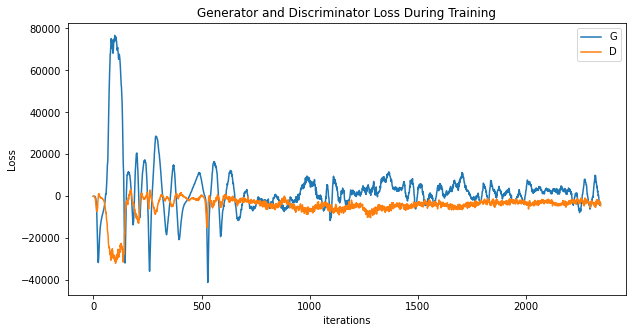

In [107]:
plot_loss(G_losses, D_losses, save = False)

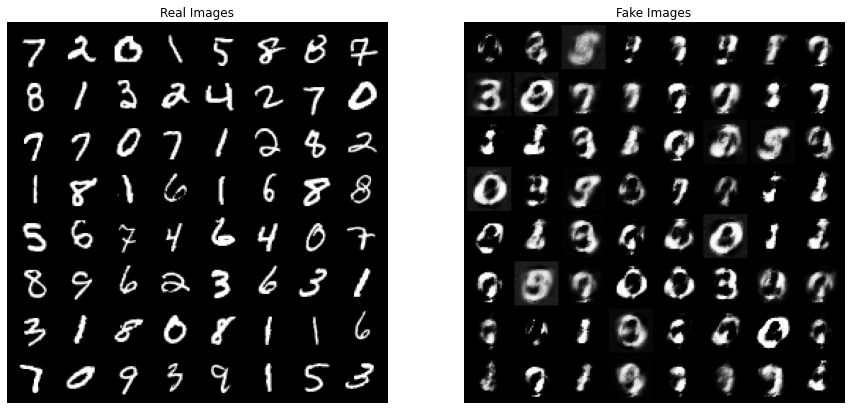

In [108]:
plot_realvsfake(dataloader, device, img_list, save = False)

## G’s progression



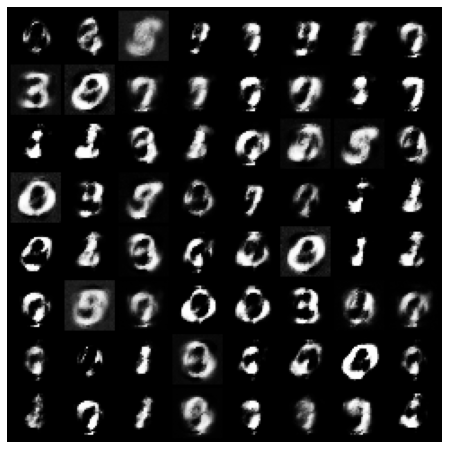

In [109]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Serialization

In [123]:
epoch = 999999999
experiment_prefix = 'tteeesst'
experiment_path, stats_path, models_path = generate_paths(PATH, experiment_prefix, loss_name, lrD, lrG, beta1, iter_dis, iter_gen, gp_val, create_dir=True)
save_path_G, save_path_D = model_paths(experiment_path, epoch, models_path)

print(experiment_path)
print(stats_path)
print(save_path_G)
print(save_path_D)

./generated_data/tteeesstwassLoss_lrd0.0002_lrg0.0002_b1b0.9_itd5_itg1_gpv10.0_2022_06_14_
./generated_data/tteeesstwassLoss_lrd0.0002_lrg0.0002_b1b0.9_itd5_itg1_gpv10.0_2022_06_14_/stat.pickle
./generated_data/tteeesstwassLoss_lrd0.0002_lrg0.0002_b1b0.9_itd5_itg1_gpv10.0_2022_06_14_/models/model_G_999999999
./generated_data/tteeesstwassLoss_lrd0.0002_lrg0.0002_b1b0.9_itd5_itg1_gpv10.0_2022_06_14_/models/model_D_999999999


In [124]:
save_models(netG ,netD, save_path_G, save_path_D)

GAN saved


In [125]:
pickle_save(stats, stats_path)

In [126]:
# load model
netD, netG = load_models(ngpu, Discriminator, Generator, save_path_G, save_path_D)

stats = pickle_load(stats_path)

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
GAN loaded


# Metrics

In [41]:
def sample_gen(netG, nz, data):
    with torch.no_grad():
      real_cpu = data[0].to(device)
      b_size = real_cpu.size(0)

      noise = torch.randn(b_size, nz, 1, 1, device=device)
      fake = netG(noise)
    return real_cpu, fake

In [31]:
# Create the dataloader

batch_size_eval = 100

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size_eval,
                                         shuffle=True, num_workers=workers)


In [32]:
# Load inception model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model = inception_model.cuda()

In [42]:
# take first batch from the dataloader to get 500 samples :
with torch.no_grad():
    sample_batch = next(iter(dataloader))  

    real_cpu, fake = sample_gen(netG, nz, sample_batch)

    t_frechet = time.time()
    frechet_dist = calculate_frechet(real_cpu, fake, inception_model) 
    print('frechet dist:', frechet_dist,'| time to calculate :',time.time()-t_frechet,'s')

frechet dist: 134.52282275458674 | time to calculate : 15.862799882888794 s


# Hyper-parameter optimization (gridsearch)

In [ ]:
def run_experiment(ngpu, device, real_label, fake_label, dataset, workers,
                   batch_size, shuffle, num_epochs, fixed_noise, plot = True):
    netG = init_net(Generator(ngpu, nc, nz), device)
    netD = init_net(Discriminator(ngpu, nc, loss_name), device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

    # stats = train(netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise)
    
    # gan_training = Training(loss_name, netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise, iter_dis, iter_gen, gp_val)
    # stats = gan_training.train()

    gan_training = Training(loss_name, netD, netG, device, real_label, fake_label, 
                        dataloader, num_epochs, fixed_noise, 
                        gp_val, lrD, lrG, beta1, experiment_prefix, save_models, PATH, save_stats = True, create_dir=True,
                        iter_per_epoch_dis=1, iter_per_epoch_gen=1, grad_penalty_coef=0.0)
    
    if plot:
        plot_loss(G_losses, D_losses, save = False)
        plot_realvsfake(dataloader, device, img_list, save = False)
        
    return stats, dataloader, netG, netD

In [ ]:
gan_training = Training(loss_name, netD, netG, device, real_label, fake_label, 
                        dataloader, num_epochs, fixed_noise, 
                        gp_val, lrD, lrG, beta1, experiment_prefix, save_models, PATH, save_stats = True, create_dir=True,
                        iter_per_epoch_dis=1, iter_per_epoch_gen=1, grad_penalty_coef=0.0)

In [ ]:
def grid_search(ngpu, device, real_label, fake_label, dataset, workers,
                   batch_size_list, shuffle_list, num_epochs_list, fixed_noise_list, plot = True ):
    all_stats = [] 



    for batch_size in batch_size_list :
      for shuffle in shuffle_list :
        for num_epochs in num_epochs_list :
          for fixed_noise in fixed_noise_list :
              print('batch_size', batch_size, 'shuffle', shuffle, 'num_epochs', num_epochs)
              stats, dataloader, netG, netD = run_experiment(ngpu, device, real_label, fake_label, dataset, workers,
                            batch_size, shuffle, num_epochs, fixed_noise)
    
    all_stats.append(stats)
    
    return all_stats

In [ ]:
all_stats = grid_search(ngpu, device, real_label, fake_label, dataset, workers,
                        batch_size_list = [128, 64, 32, 16],
                        shuffle_list = [False, True],
                        num_epochs_list = [5, 10 , 20], # actually we don't need to iterate over this but I'm still putting here
                        fixed_noise_list = [ fixed_noise ], plot = True )